21


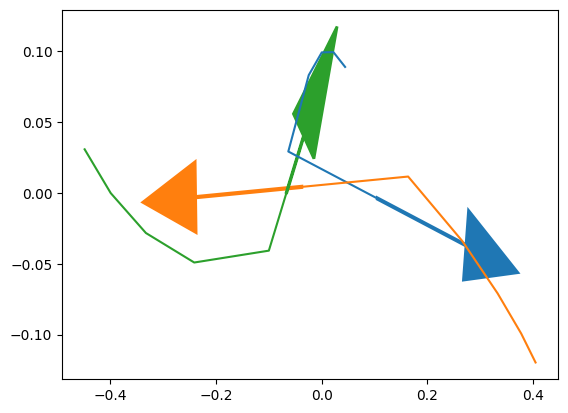

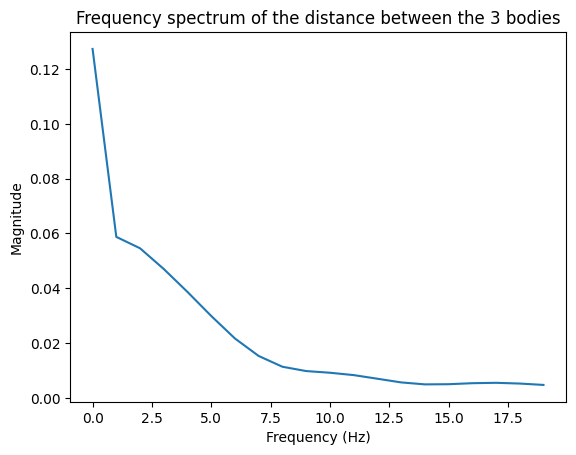

In [92]:
import numpy as np
import matplotlib.pyplot as plt

G = 1  # Gravitational constant (assuming normalized units)
mass = np.ones(3)  # Masses of the three bodies (all equal to 1)
dt = 0.001  # Time step for the simulation
max_steps = 3000  # We want to reach 1000 steps
save_interval = 10  # Save position data every 100 steps to reduce memory usage
max_distance_limit = 10  # Max inter-body distance to stop the simulation early

pattern_size= 4000

def compute_forces(positions, masses):
    forces = np.zeros_like(positions)
    for i in range(3):
        for j in range(i + 1, 3):
            diff = positions[j] - positions[i]
            distance = np.linalg.norm(diff)
            if distance > 1e-5:  # To avoid division by zero
                force_magnitude = G * masses[i] * masses[j] / distance**2
                force_direction = diff / distance
                forces[i] += force_magnitude * force_direction
                forces[j] -= force_magnitude * force_direction
    return forces


def pairwise_distances(positions):
    distances = []
    for i in range(3):
        for j in range(i + 1, 3):
            distance = np.linalg.norm(positions[j] - positions[i])
            distances.append(distance)
    return distances

from collections import deque

def run_simulation():
    positions = np.random.uniform(-1, 1, (3, 2))
    velocities = np.random.uniform(-1, 1, (3, 2))
    velocities -= np.mean(velocities, axis=0)
    positions -= np.mean(positions, axis=0)
    
    positions_over_time = []  # To store position snapshots
    distances_over_time = []  # To store pairwise distances at each saved timestep
    saved_step = 0
    for step in range(max_steps):
        forces = compute_forces(positions, mass)
        velocities += forces * dt  # Update velocities based on forces
        positions += velocities * dt  # Update positions based on velocities
        
        # Check for max inter-body distance and stop if it exceeds 10
        if max(pairwise_distances(positions)) > max_distance_limit:
          #  print(f'Simulation stopped at step {step} due to max inter-body distance exceeding 10.')
            return np.array(positions_over_time), np.array(distances_over_time), step
        
        # Save position data and pairwise distances at intervals
        if step % save_interval == 0:
            saved_step+=1

            if len(positions_over_time) < pattern_size:
                positions_over_time.append(positions.copy())
                distances_over_time.append(pairwise_distances(positions))
            elif saved_step%2==0:
                    positions_over_time =positions_over_time[1:]
                    distances_over_time =distances_over_time[1:]
                    positions_over_time.append(positions.copy())
                    distances_over_time.append(pairwise_distances(positions))
             

    
    # Convert to NumPy arrays for easier manipulation later
    positions_over_time = np.array(positions_over_time)
    distances_over_time = np.array(distances_over_time)
    
    return positions_over_time, distances_over_time, step


positions_over_time, distances_over_time, timestep = run_simulation()
    


# compute the modulus of the vector made by the 3 bodies distance over time
norm_over_time = np.linalg.norm(distances_over_time, axis=1)



# Plotting the trajectory of the bodies from the successful simulation
for i in range(3):
    # add an arrow to show the direction of the movement
    plt.plot(positions_over_time[::5, i, 0],
                positions_over_time[::5, i, 1], 
                label=f'Body {i+1}', color='C'+str(i))
    plt.arrow(positions_over_time[::5, i, 0][-1],
                positions_over_time[::5, i, 1][-1],
                positions_over_time[::5, i, 0][-1]-positions_over_time[::5, i, 0][-2],
                positions_over_time[::5, i, 1][-1]-positions_over_time[::5, i, 1][-2],
                head_width=0.05, head_length=0.1, fc='C'+str(i), ec='C'+str(i), 
                lw=2)

def plot_fft_up_to_1hz(distance_series):
    # Perform FFT

    N=len(distance_series)

    if N<pattern_size:
        # make 4000 points
        distance_series = np.interp(np.linspace(0, N, pattern_size), np.arange(N), distance_series)
        
        d=save_interval * dt  * N/pattern_size
    else:
        d=save_interval * dt  

    distance_fft = np.fft.fft(distance_series)
    freqs = np.fft.fftfreq(pattern_size, d=d)

    # Normalize the FFT magnitude
    magnitude = np.abs(distance_fft) / pattern_size

    # Filter frequencies up to 1 Hz
    mask = (freqs >= 0) & (freqs <= 100)  # Only keep positive frequencies up to 1 Hz
    freqs_filtered = freqs[mask]
    magnitude_filtered = magnitude[mask]

    # interpolate to make it of size 20
    magnitude_filtered = np.interp(np.linspace(0, 100, 20), freqs_filtered, magnitude_filtered)

    # Plot the frequency spectrum up to 1 Hz
  #  plt.plot(freqs_filtered, magnitude_filtered)
  #  return freqs_filtered, magnitude_filtered
    return freqs_filtered, magnitude_filtered



freqs,magnitudes=plot_fft_up_to_1hz(norm_over_time/10)


# concatenate timestep with magnitudes
embedding = np.concatenate((np.array([timestep]),magnitudes))
embedding

print(len(embedding))


plt.figure()
# plot the frequency spectrum
plt.plot( magnitudes)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum of the distance between the 3 bodies')

plt.show()